# <center>機械学習 第4回 「Pythonによる単回帰」</center>
<center>2024年5月7日　瀧雅人</center>

機械学習ライブラリの様子を知り、使い方に慣れる。また今回から実際の作業をすることで、Numpyを使ったデータの扱い等に慣れてゆく。

- Numpy配列データの処理
- scikit-learnによる線形単回帰：正規方程式と勾配法
- ブートストラップによる信頼区間＊
- scratchからの線形単回帰＊



＊印はアドバンスな話題なので、初回は＊なしの部分の理解に注力し、後に＊の部分も補っていく。

まずは、Google Driveを<b>マウント</b>する：

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <center>scikit-learnによる単回帰</center>


# 1.データの準備

csvファイルをテキストとして`numpy`の`loadtxt()`関数で読み込む

In [ ]:
import numpy as np

squad = np.loadtxt("/content/drive/My Drive/ml_datasets/squad.csv", delimiter=",")

Numpyの配列(ndarray)として読み込まれたデータ(計画行列)
のうち、はじめ10個のインスタンスを見てみる：

In [ ]:
squad[:10]

array([[1.5583968e+09, 8.9898000e+01],
       [1.5654816e+09, 8.9646000e+01],
       [1.5682464e+09, 8.9709000e+01],
       [1.5704928e+09, 8.9101000e+01],
       [1.5693696e+09, 8.8912000e+01],
       [1.5636672e+09, 8.8839000e+01],
       [1.5621120e+09, 8.8650000e+01],
       [1.5636672e+09, 8.7465000e+01],
       [1.5386976e+09, 8.7433000e+01],
       [1.5577920e+09, 8.6940000e+01]])

1列目と2列目をそれぞれ切り出す（Numpy配列の<b>スライシング</b>）：

In [ ]:
X = squad[:,0]
y = squad[:,1]

まずは散布図で、データの様子をざっと確認：

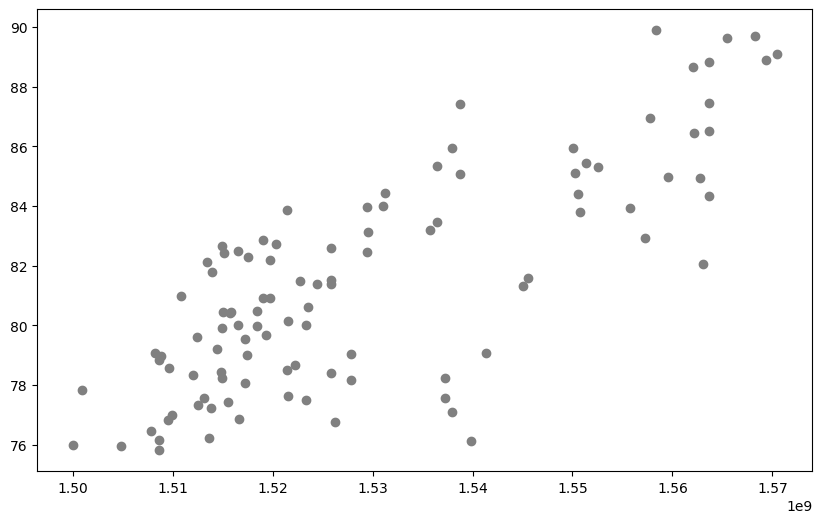

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.scatter(X, y, c='gray')

実はこのデータは、2017年7月から2018年10月の間の<b>代表的な言語理解AI達が、どれほど言語テストで点数をとったか</b>を記録したものです。AIの学習・テストに使われたのはSQuADという言語テストデータです。

散布図の各インスタンス(点)が各AIです。横軸の`X`の値は、そのAIが公開された日時をとある数値(UNIX時間）で表したものです。縦軸`y`は、各AIがテストで叩き出した点数です。

現在では自然言語処理の機械学習が90点以上を叩き出す大発展を見せています。実は平均的な人間の点数は82.44で、とっくにAIに追い抜かされています。

さて、我々のデータ`X`はベクトル（形が`(N,)`の配列）です：

In [ ]:
X.shape

(104,)

中身を全部表示してみると、一つの`[]`に囲まれて`104`個の数値が格納されています：

In [ ]:
X

array([1.5583968e+09, 1.5654816e+09, 1.5682464e+09, 1.5704928e+09,
       1.5693696e+09, 1.5636672e+09, 1.5621120e+09, 1.5636672e+09,
       1.5386976e+09, 1.5577920e+09, 1.5636672e+09, 1.5621984e+09,
       1.5501024e+09, 1.5379200e+09, 1.5513120e+09, 1.5525216e+09,
       1.5595200e+09, 1.5386976e+09, 1.5627168e+09, 1.5502752e+09,
       1.5364512e+09, 1.5636672e+09, 1.5505344e+09, 1.5312672e+09,
       1.5558048e+09, 1.5507072e+09, 1.5310080e+09, 1.5572736e+09,
       1.5294528e+09, 1.5214176e+09, 1.5364512e+09, 1.5357600e+09,
       1.5295392e+09, 1.5202944e+09, 1.5294528e+09, 1.5165792e+09,
       1.5189984e+09, 1.5258240e+09, 1.5149376e+09, 1.5151104e+09,
       1.5630624e+09, 1.5196896e+09, 1.5175296e+09, 1.5455232e+09,
       1.5134688e+09, 1.5450048e+09, 1.5139008e+09, 1.5258240e+09,
       1.5244416e+09, 1.5258240e+09, 1.5227136e+09, 1.5196896e+09,
       1.5108768e+09, 1.5189984e+09, 1.5183936e+09, 1.5234912e+09,
       1.5158016e+09, 1.5150240e+09, 1.5157152e+09, 1.5165792e

講義では一般論を意識して、データは行列で扱いました。その流儀に合わせると、特徴量が1つしかない今の場合も、`X`は`(N,1)`という二つの軸をもつ配列であるべきです。

そこでベクトルを行列にします。
次の<b>軸を加える操作はよく使う</b>ので覚えておく：

In [ ]:
X = X[:, np.newaxis]
# yは必ずしもこうしなくてもいいのですが、以下スクラッチ実装簡単化のため
y = y[:, np.newaxis]

あるいは予め切り出すときに
```
X = squad[:,0:1]
y = squad[:,1:]
```
とすればいい。

すると、長さ1の自明な軸が加わっている:

In [ ]:
X.shape

(104, 1)

この長さ`1`の軸は、次のように一個一個の数字がカッコでくくられた事に対応：

In [ ]:
X

array([[1.5583968e+09],
       [1.5654816e+09],
       [1.5682464e+09],
       [1.5704928e+09],
       [1.5693696e+09],
       [1.5636672e+09],
       [1.5621120e+09],
       [1.5636672e+09],
       [1.5386976e+09],
       [1.5577920e+09],
       [1.5636672e+09],
       [1.5621984e+09],
       [1.5501024e+09],
       [1.5379200e+09],
       [1.5513120e+09],
       [1.5525216e+09],
       [1.5595200e+09],
       [1.5386976e+09],
       [1.5627168e+09],
       [1.5502752e+09],
       [1.5364512e+09],
       [1.5636672e+09],
       [1.5505344e+09],
       [1.5312672e+09],
       [1.5558048e+09],
       [1.5507072e+09],
       [1.5310080e+09],
       [1.5572736e+09],
       [1.5294528e+09],
       [1.5214176e+09],
       [1.5364512e+09],
       [1.5357600e+09],
       [1.5295392e+09],
       [1.5202944e+09],
       [1.5294528e+09],
       [1.5165792e+09],
       [1.5189984e+09],
       [1.5258240e+09],
       [1.5149376e+09],
       [1.5151104e+09],
       [1.5630624e+09],
       [1.519689

# 2.訓練セットとテストセット

データを訓練用とテスト用に分割するには、`model_selection`モジュールの中の`train_test_split`メソッドを用いるのが楽：

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

分割後の形は

In [ ]:
X_train.shape

(66, 1)

20%をテストデータに、残り80%のうちの20%(つまり全体の`80*0.2=16`%)を検証データに、残りを訓練データに割り振る。分割前に勝手にシャッフル。

- 'random_state'でシャッフルに使う擬似乱数のシードを指定できる。

# 3.正規方程式による学習

単回帰を利用するには、`sklearn.linear_model.LinearRegression`から一つインスタンスを生成します：

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

学習は、LinearRegressionの`fit()`メソッドで行えます。

引数にデータを渡します。

In [ ]:
reg.fit(X_train, y_train)

LinearRegression()

学習後の係数`a`の値は、`coef_`という属性です

In [ ]:
reg.coef_

array([[1.36602942e-07]])

ここで注意として、
```python
reg.coef_ = 10.0
```
などというコードを書いてはいけません。学習した結果が`10.0`に書き換えられてしまいます。

学習後の切片`b`の値

In [ ]:
reg.intercept_

array([-127.67673911])

スコア（$R^2$）も簡単に計算できます：

In [ ]:
reg.score(X_train, y_train)

0.5030043288265401

検証スコアは

In [ ]:
reg.score(X_val, y_val)

0.7342312150034715

散布図の上に、学習後の直線をプロットすることもできます。学習後の回帰直線は`y=reg.predict(x)`と書けるので、これを検証データの上にプロットすると

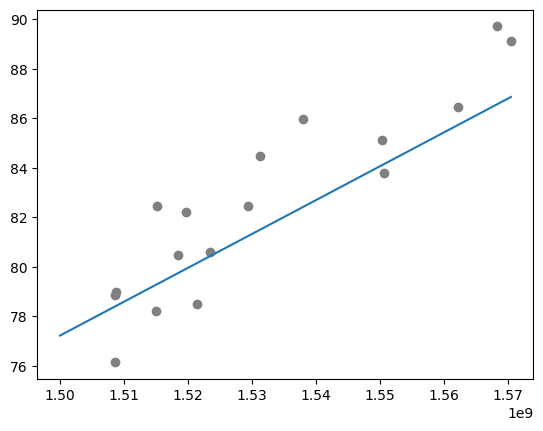

In [ ]:
x_line = np.linspace(np.min(X),np.max(X),100) # Xの最小値から最大値までの範囲を100分割した数値
y_line = reg.predict(x_line[:,np.newaxis])

plt.plot(x_line, y_line)
plt.scatter(X_val, y_val, c='gray')

# 4.ブートストラップと信頼区間＊

さて、一個のデータから一回だけ学習させた一個だけの結果は<b>どれだけ信頼がおけるのでしょう？</b>偶然に左右されてたまたま例外的な結果が出ただけかもしれません。ランダムな影響で記録されたデータが少し違えば、学習結果も変わったことでしょう。<b>データのサンプリングが変わったとしても、推定しようとしているもの（データの背後にある「真実」）は同じ</b>です。データが変わるごとに結果が大きく変わってしまったら、うまく推定できていないことになります。

もし同じ条件で何回もデータがサンプリングできるなら、データがどれほどばらつき得るのがわかります。結果として、それらデータ達から得られる推定値のばらつきもわかります。つまり母集団から何度もデータをサンプリングできるなら、何度も回帰分析を繰り返し、推定結果のブレを見ることができます。

ところが、我々の「2017-2018年の言語AIの発展データ」を、他にもたくさん得ることなどできるでしょうか？もう過ぎ去った一度きりの過去のデータです。「並行宇宙（パラレルワールド）」に行って、「それぞれの宇宙の地球」でAIの進展を調査しなくてはならないのでしょうか！？

これは冗談の例えとしても、我々は普通、<b>手元にある以上のデータを何度も再入手する機会を持ちません</b>。ではどうやって「もし違うデータが手に入った場合のばらつき具合」なぞを知ることができるのでしょうか？？

## 4-1.リサンプリング


ここで活躍するのがリサンプリングです。手元のデータだけから復元抽出を繰り返すことで、擬似的に新たなデータのサンプリングを生成する技法です。

元データと同じサイズのデータを、インスタンスを復元抽出することで作ります。得られたデータセットを<b>ブートストラップサンプル</b>と言います。

もちろん黒魔術ではありませので、手元の小さなデータから母集団がわかる訳ではありません。そうではなく、今我々が持っている一つのデータの情報だけから、「どれほど母集団からのサンプリングがばらつき得ると言えるのか」を見積もってくれるのです。

`resample`関数を使って愚直にブートストラップ法を実行して見ます

In [ ]:
from sklearn.utils import resample

n_iters = 1000# リサンプリング回数
size = X_train.shape[0]# データサイズ

coefs = list()# リサンプリング毎の推定パラメータをここに記録
intercepts = list()# リサンプリング毎の推定パラメータをここに記録

for _ in range(n_iters):
    X_resample, y_resample = resample(X_train, y_train, n_samples=size)
    reg = LinearRegression()
    reg.fit(X_resample, y_resample)
    coefs.append(reg.coef_[0,0])
    intercepts.append(reg.intercept_[0])

この1000個のブートストラップによるパラメータ推定値が、どのくらいのばらつきがあるのかを見てましょう。推定値の振れ幅、つまり推定されたパラメータの信頼区間の中に0が入っていたら、得られた係数は有意ではないことになります（→統計学）。つまりその係数がゼロの可能性があります。

そこでブートストラップの結果を見て見ましょう。まず係数のブートストラップ平均は

In [ ]:
np.mean(coefs)

係数は`0.0000001...`とすごい小さい値です。やはり実質これは0かもしれない、という疑いが起こります。これでは線形回帰の意味がありません。

そこで次に<b>ヒストグラム</b>をプロットして分布を可視化しましょう：

In [ ]:
plt.hist(coefs,bins=100)
plt.show()

係数は実質0かもしれないと疑われましたが、どうも分布は0から離れたところにあるので、0ではなさそうです。

## 4-2.ブートストラップ信頼区間

その不確定さの範囲を表す<b>信頼区間</b>を見ると、不確かさを考慮して値を区間として推定できます。

例えば95%信頼区間（<b>パーセンタイル・ブートストラップ信頼区間</b>）とは、ブートストラップ推定値を大きさ順に並べた時、<b>下位2.5%、上位2.5%を切り捨てた残り95%の値が存在している範囲</b>です。

今はトータル1000個あるから、ソートすると下位2.5%には25個。したがって範囲の左端は26番目の

In [ ]:
np.sort(coefs)[25]

上位97.5%は275個目からなので、範囲の右端は

In [ ]:
np.sort(coefs)[975-1]

今はトータル1000個あるから、値を小さい順からソートすると95%区間は26個目〜975個目の範囲

In [ ]:
coef_l = np.sort(coefs)[25]
coef_r = np.sort(coefs)[975-1]
print('95%信頼区間','[',coef_l,',',coef_r,']')

95%の信頼水準でこの範囲にあることになるので、安心して0から離れていると見なせますます。(真の係数が0.95の確率でこの範囲に存在する、という意味では<b>ありません</b>。なぜなら点推定では真値は確率変数ではないからです。信頼水準の正しい意味については、統計学を参照。)

線形回帰の場合は、t統計量などを使うことで仮説検定や信頼区間の計算ができます（統計学を参照）。しかし一般には、ブートストラップの方がデータ・モデルに仮定がほとんど必要なく、広く使える強力な手法です。

大昔はブートストラップは計算コストから回避されていたようですが、現代ではコンピュータの性能向上のおかげで実務に広く使われています。

そればかりか実務の場面では、標準誤差を用いた信頼区間の公式を使った計算法よりも、ブートストラップの方が良くなる場合が多いです。それは標準誤差の計算に必要な母集団分散の推定のための仮定が、実際のデータでは満たされていないことが多いためです。

重たい学習計算では、それを1000回も繰り返すのは大変そうです。しかし上の計算は完全に並列化できるので、コア数が多い環境ではそこまで恐れる必要はありません。並列化を考えて見ましょう。

# 5.勾配降下法による学習

先ほどは正規方程式による回帰モデルでした。勾配法による学習も実装されています。学習率`0.1`で`5000`回勾配降下計算を反復して見ましょう。

In [ ]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=5000, eta0=0.1)

学習：

In [ ]:
reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(eta0=0.1, max_iter=5000)

↑ 他にも色々な引数が渡せます。<b>自分で色々引数の意味を調べて、引数を変える学習実験をして見ましょう</b>。

別の学習法を用いたので、先ほどとは違うパラメータ値が得られました：

In [ ]:
reg.coef_

array([-2.50082356e+17])

In [ ]:
reg.intercept_

array([3.14028839e+10])

学習法を変えたので、スコアも変わります：

In [ ]:
reg.score(X_train, y_train)

-1.227678773280637e+52

<b>さて訓練性能が恐ろしく悪いのはなぜでしょう？</b>

## 5-1.スケーラーによるデータの前処理

`X`の単位はUNIX時間で、10桁の数値になっています。そのため値のスケール感が大きすぎて、勾配法がうまく進行する適切な「歩幅」（学習率、eta0）の値がよくわからなくなってしまっているからです。

きちんとScalerで特徴量の数値的なスケール感を整えましょう。

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

Scalerもモデルと同じで、`fit`メソッドでデータに適用できます。実際にデータを変換するのは`transform`メソッドです：

In [ ]:
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

In [ ]:
reg = SGDRegressor(max_iter=5000, eta0=0.1)
reg.fit(X_train_scaled, y_train)

reg.score(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5017121000646143

テスト性能（検証性能）は、<b>訓練セットに関して`fit`した後の`scaler`で変換します。テストセットで`fit`し直してはいけません</b>。

In [ ]:
X_val_scaled = scaler.transform(X_val)

reg.score(X_val_scaled, y_val)

0.7534595240977716

## 5-2.valも同じscalerで変換しなくてはいけない理由

おもちゃデータ

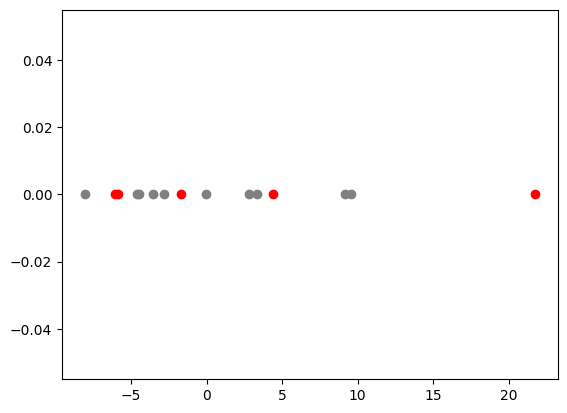

In [ ]:
X_toy = 10*np.random.randn(10,1)
X_toy_val = 10*np.random.randn(5,1)
plt.scatter(X_toy,np.zeros_like(X_toy),c='gray')
plt.scatter(X_toy_val,np.zeros_like(X_toy_val),c='red')

正しいscalingのやり方

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_toy)
X_toy_scaled = scaler.transform(X_toy)
X_toy_val_scaled = scaler.transform(X_toy_val)

すると<b>訓練データと検証データの相対的位置関係は全く同じ</b>：

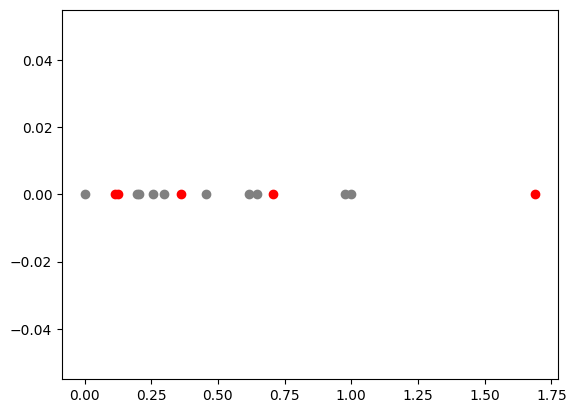

In [ ]:
plt.scatter(X_toy_scaled,np.zeros_like(X_toy),c='gray')
plt.scatter(X_toy_val_scaled,np.zeros_like(X_toy_val),c='red')

誤ったやり方では、検証データが<b>全く違う分布</b>になってしまう：

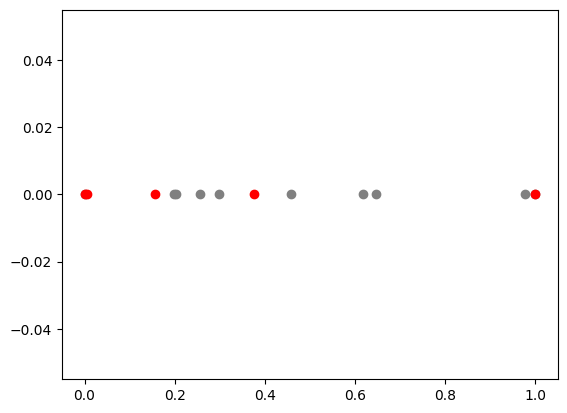

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_toy)
X_toy_scaled = scaler.transform(X_toy)
scaler.fit(X_toy_val)
X_toy_val_scaled = scaler.transform(X_toy_val)
plt.scatter(X_toy_scaled,np.zeros_like(X_toy),c='gray')
plt.scatter(X_toy_val_scaled,np.zeros_like(X_toy_val),c='red')

# <center>単回帰のスクラッチ実装＊</center>

では、先ほどのライブラリはどのようにできていたのでしょう？似たものをスクラッチから作ってみましょう。

- 座学で学習した仕組みを、コーディングを通じて理解する。
- Pythonコーディングに徐々に慣れる。
- Numpy配列の操作、クラスを使うのメリット等々に慣れる

問題形式なので、復習時には自分で解きながら実装を再現してみましょう。

# 6.回帰モデルの復習とNumPyによる実装＊

### 単回帰の目的
> 与えられた入力値`x`に対応する出力値`y`をできるだけ正確に予想する

### 単回帰の学習
> たくさんの入・出力値のペアの具体例（<b>インスタンス</b>）の集合 $(x_1,y_1),(x_2,y_2)\cdots,(x_N,y_N)$を用意し、ここから入・出力の間の関係（パターン）を<b>学習</b>。

### 単回帰モデル
$\hat{y\,}$（$y$の<b>予測値</b>）を計算する次の線形モデルが回帰モデル
>\begin{align}
\hat{y\,}(x;a,b)=ax+b
\end{align}

- 学習 = 適切な<b>パラメータ</b>$a,b$の値をデータから決めること。
- 学習には<b>勾配降下法</b>を用いる。

### 問1 : 学習パラメータの初期化
パラメータaとbを、区間[-1,1]の<b>一様な乱数</b>を使って初期化しなさい（乱数の発生にはnumpyのrandomモジュールを用いると良い）。

<b>答え</b>

In [ ]:
a = 2 * np.random.rand() - 1
b = 2 * np.random.rand() - 1

モジュールを使って発生できる乱数の区間は[0,1]なので、二倍して1を引く。randomモジュールについては例えば
https://qiita.com/takahiro_itazuri/items/47fc35843b6a5435a33f

### 問2：線形モデル
xが与えられた時に、パラメータa、bを使って予測値 $\hat{y\,}$ を返す関数`predict(x)`を定義しなさい。

<b>答え</b>

In [ ]:
def predict(x):

    y_hat = a * x + b

    return y_hat

<b>注意</b>

配列の足し算に備わる<b>ブロードキャスト機能</b>を思い出しましょう

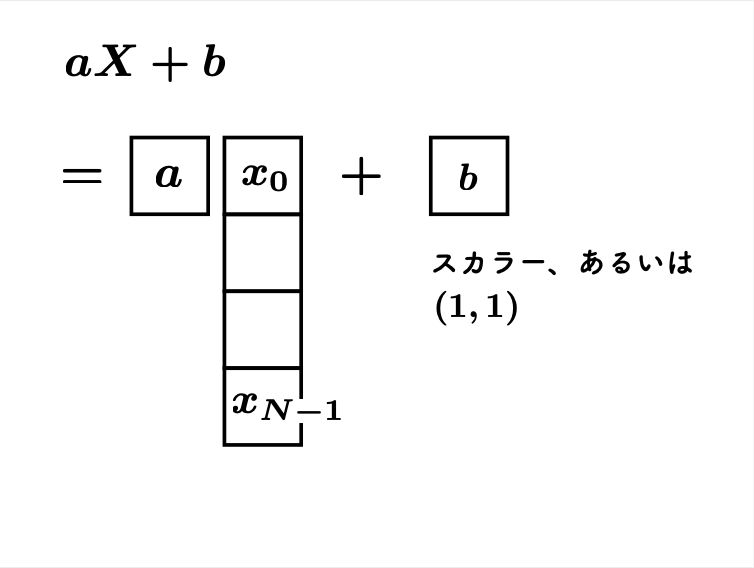

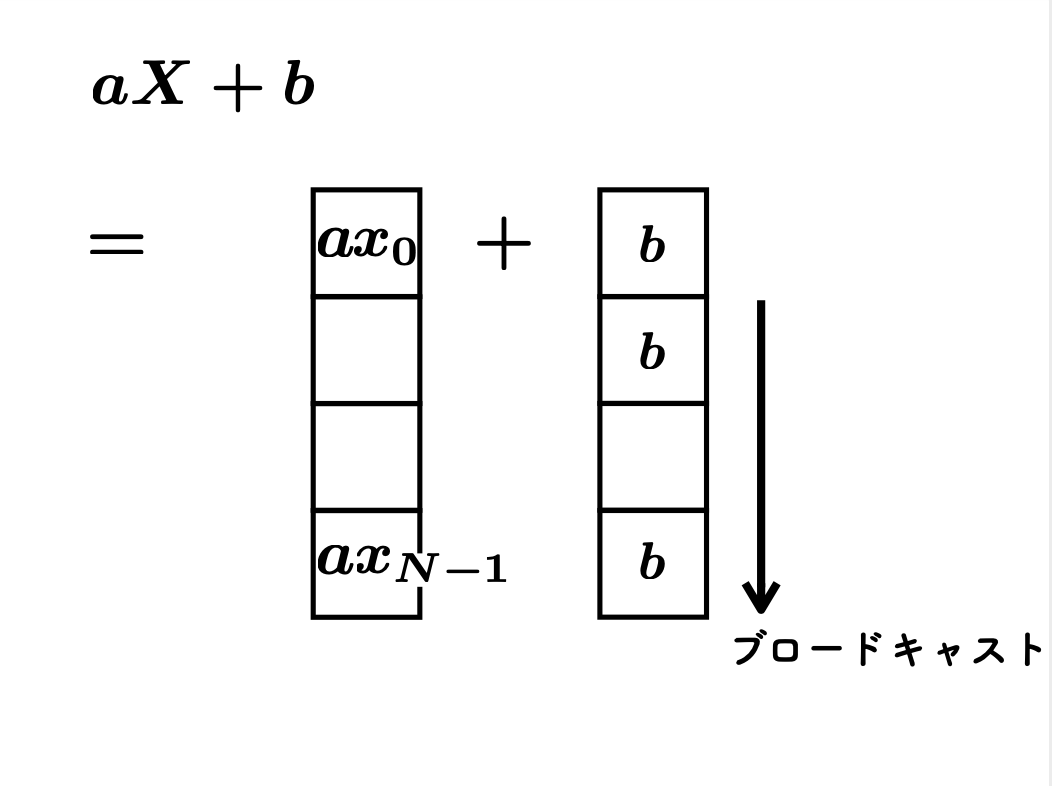

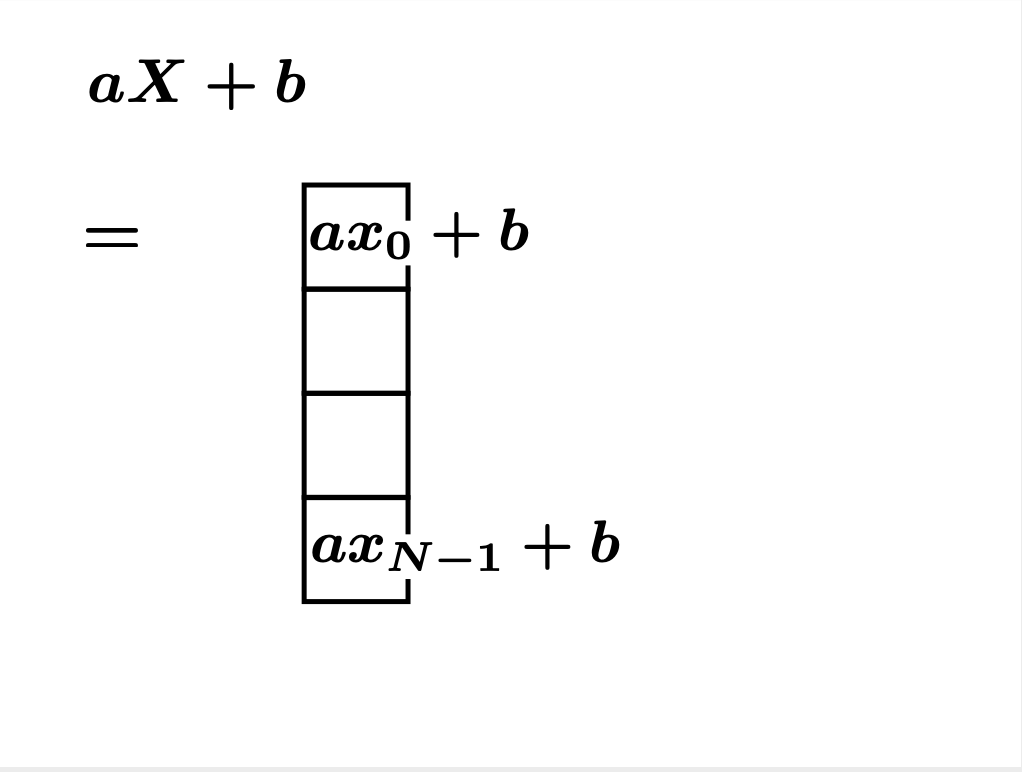

# 7.勾配降下法の復習とNumPyによる実装＊

学習は誤差関数


\begin{align}
E(a,b)
=
\frac{1}{N}
\sum_{n=1}^N\bigg(\,\hat{y\,}(x_n;a,b)-y_n\,\bigg)^2
\end{align}

を最小にするパラメータを探す作業でした。

## 問3：誤差関数の勾配の性質
二つのパラメータに関する勾配を数学的に計算しましょう（講義ノートで復習！）

\begin{align}
\frac{\partial E(a,b)}{\partial a}=\,\, ?
\end{align}

\begin{align}
\frac{\partial E(a,b)}{\partial b}=\,\, ?
\end{align}

## 答え

\begin{align}
\Delta y_n (a,b)= \hat{y\,}(x_n;a,b)-y_n
\end{align}
という記号を使うと

\begin{align}
\frac{\partial E(a,b)}{\partial a}= \frac{2}{N}\sum_n
x_n\,\Delta y_n (a,b)
\end{align}

\begin{align}
\frac{\partial E(a,b)}{\partial b}=\frac{2}{N}\sum_n
\,\Delta y_n (a,b)
\end{align}

さらに配列で書くと

\begin{align}
\frac{\partial E(a,b)}{\partial a}
=\frac{2}{N}
\begin{pmatrix}x_1&\cdots&x_N\end{pmatrix}
\begin{pmatrix}\Delta y_1\\\vdots\\\Delta y_N\end{pmatrix}
= \frac{2}{N}X^\top\Delta Y (a,b)
\end{align}

\begin{align}
\frac{\partial E(a,b)}{\partial b}=\frac{2}{N}
\begin{pmatrix}1&\cdots&1\end{pmatrix}
\begin{pmatrix}\Delta y_1\\\vdots\\\Delta y_N\end{pmatrix}
= \frac{2}{N}I^\top\Delta Y (a,b)
\end{align}

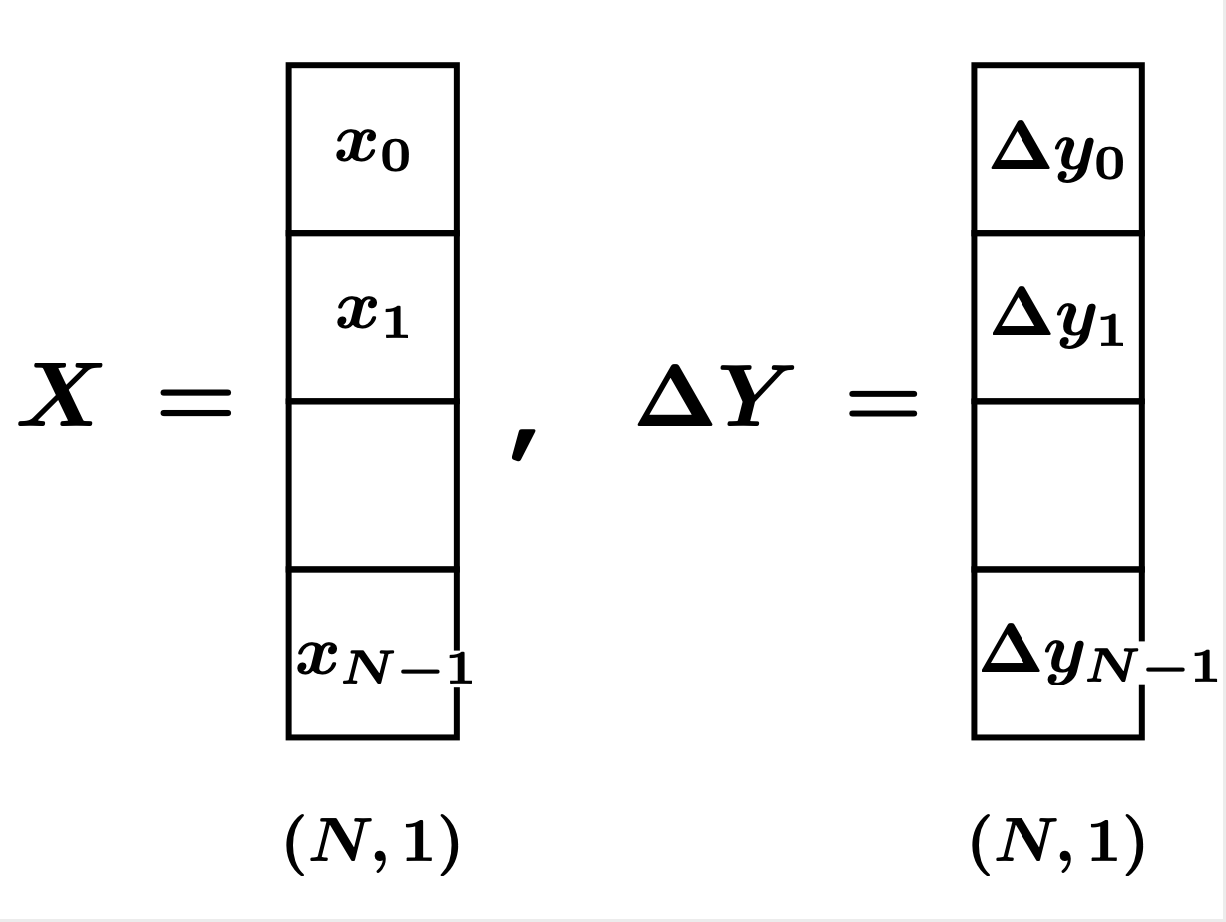

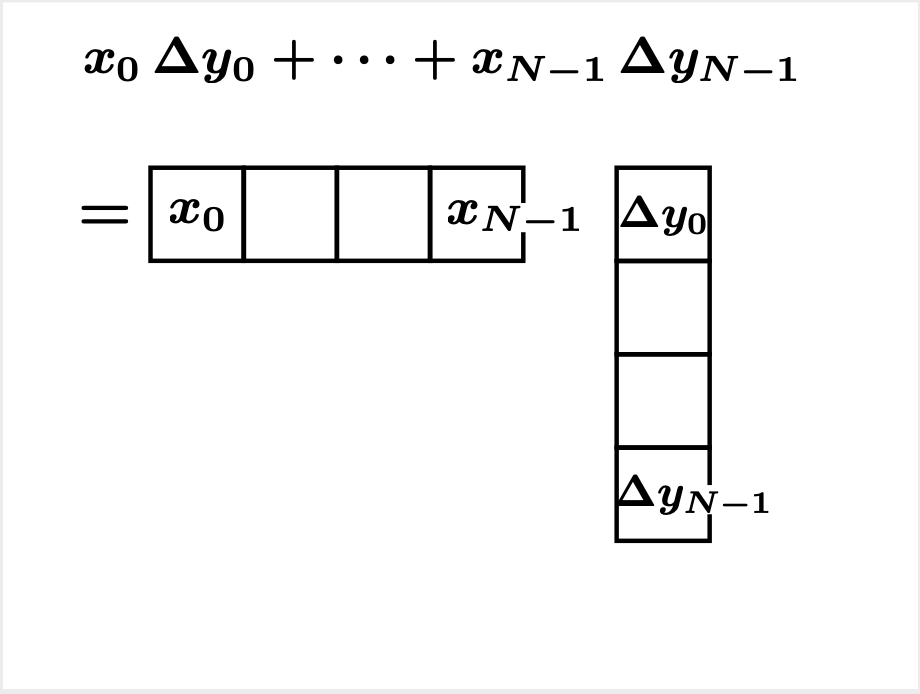

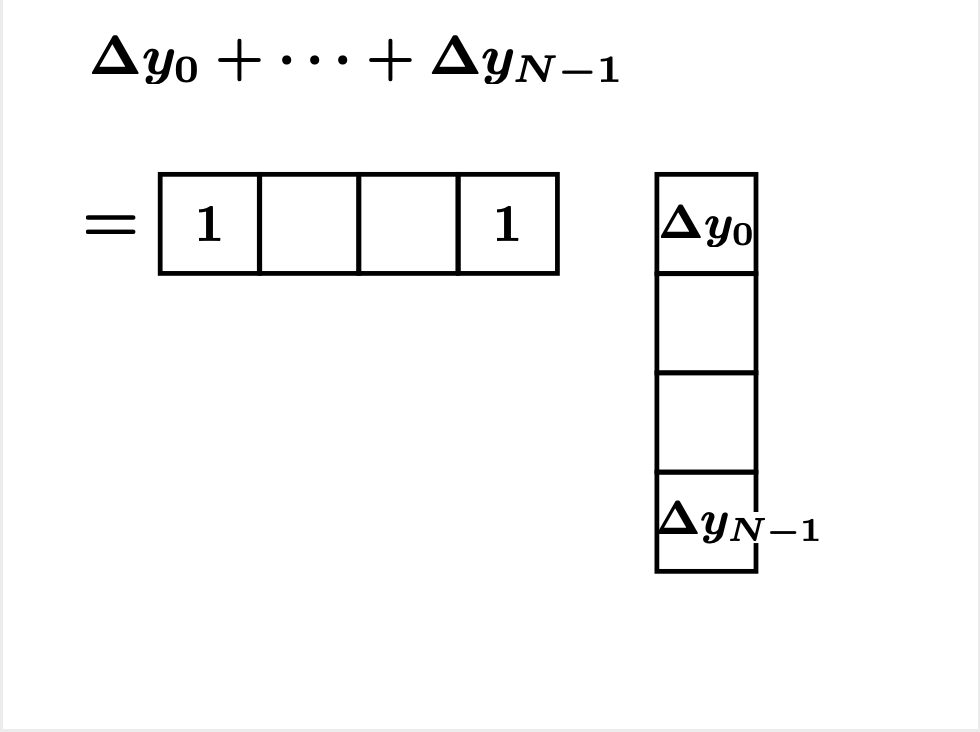

## 問4：勾配計算
上の式を用いて、勾配を計算するコードを書きましょう。

ただしデータはそれぞれshape (N,1)の配列`X`、`y`として与えられるものとします。<b>`X`と`y`を引数として、`a`と`b`の勾配の値を返す関数`grad_a()`と`grad_b()`</b>を作りましょう：

## 答え

In [ ]:
def grad_a(X, y):
    N = X.shape[0]
    da = 2/N * X.T @ (predict(X) - y)
    return da

In [ ]:
def grad_b(X, y):
    N = X.shape[0]
    I = np.ones_like(y)
    db = 2/N * I.T @ (predict(X) - y)
    return db

平均値でも良い

In [ ]:
def grad_b(X, y):

    db = 2 * np.mean(predict(X) - y)

    return db

<details>
このように計算したda、dbはスカラーではなくサイズ`(1,1)`の配列になっています。
Q.なんででしょうか？<summary><b>細かい注意事項</b>(クリック)</summary></details>

この関数を使うと、勾配降下法１ステップは次のようにかけます：

```python
eta = 0.01# 学習率

a = a - eta * grad_a (X, Y)
b = b - eta * grad_b (X, Y)
```

## 問5：勾配降下法
学習率0.1で、この勾配降下法を`epochs=1000`繰り返しなさい。

## 答え

In [ ]:
print('a =', a, ', b =',b)

a = -0.1756869077937253 , b = 0.14287451199613233


In [ ]:
epochs = 1000
eta = 0.1

for i in range(epochs):
    a, b = a - eta * grad_a(X_train_scaled, y_train), b - eta * grad_b(X_train_scaled, y_train)

In [ ]:
print('a =', a, ', b =',b)

a = [[8.94636709]] , b = 77.2263279144062


初期値はスカラーなのに、この実装法では学習後は`(1,1)`の配列になっています。

Q.なんででしょう？

ただこのやり方では実用の場面では不便で、いろいろと間違いを引き起こしやすいです。なぜなら、例えば次に別のデータを回帰する場合には`a,b`の初期化を忘れてはいけませんし、そうすると前回の学習結果の`a,b`は消えてしまいます。前回の結果を並行して解析したい場合は不便です。また`a`などという使いがちな変数名をつけたため、他の場所で`a`が書き換えられてしまう可能性もあります。

そこで以上の機能を<b>クラス</b>にまとめます。

# 8.クラス入門

クラスというのは、オブジェクト（インスタンス）の設計図です。独自のクラスを実装することで、色々な値や機能をひとまとめにした望みのオブジェクトを作ることができます。

とはいえ初めて学ぶ方はこの説明ではピンとこないでしょう。とりあえず次の例題で手を動かして少し理解に挑戦しましょう：

<b>例題：次の二つを実装しなさい：
- くじ１：確率0.5で「あたり」、確率0.5で「外れ」を`print`する
- くじ２：確率0.2で「大吉」、確率0.8で「凶」を`print`する</b>

それぞれ二つの関数で実装しても良いのですが、くじ１と２は共通の性質をたくさん持っているので、一つのクラスを使って実装してみます

そこで問題を次のように言い換えます

：<b>確率pで`output1`、確率1-pで`output2`を`print`するクラスを実装する</b>。

例えば`spam`という名前の関数は
```python
def spam():
    . . .
```
と定義しましたが、`Spam`という名前のクラスは
```python
class Spam():
    . . .
```
という形で定義できます。中身には色々なものを詰めこむことができますが、まずは<b>コンストラクタ</b>から

これから作るクラスは`Lottery`という名前にしましょう。この設計図から作られる各くじは、あたり確率`p`と、出力文`output1`、`output2`を中身に持っていなくてはなりません（インスタンス変数）：

In [ ]:
class Lottery():
    def __init__(self, p, output1, output2):
        self.p = p
        self.output1 = output1
        self.output2 = output2

第一引数`self`は、この設計図から生成される各オブジェクトを指し示すためのもので、`self`と書くのが作法です。今は意味がわからなくても、とりあえず「こういうものか」と思ってください。

この設計図から作られるくじオブジェクトの、実際のくじ引き動作を<b>`draw`というメソッド</b>で定義してみます：

In [ ]:
class Lottery():
    def __init__(self, p, output1, output2):
        self.p = p
        self.output1 = output1
        self.output2 = output2

    def draw(self):
        if np.random.rand()<self.p:
            print(self.output1)
        else:
            print(self.output2)

「くじ１」の要件を満たすオブジェクトを、このクラスから生成して見ましょう：

In [ ]:
lottery1 = Lottery(0.5, 'あたり', '外れ')

くじを引くには、このオブジェクトの`draw`メソッドを実行すればいいのです：

In [ ]:
lottery1.draw()

外れ


「くじ２」は<b>同じクラス</b>の<b>別のブシェクト</b>として

In [ ]:
lottery2 = Lottery(0.2, '大吉', '凶')

In [ ]:
lottery2.draw()

凶


プログラミングやオブジェクト指向が初めての方は、しばらく理解（慣れ）に時間がかかります。今後繰り返し触れることで消化していってください。

# 9.クラスによる実装＊


## 問6：回帰のクラス実装
以上で準備の終わった部品を全て組み上げて、クラスの形で実装しましょう。

クラスの定義における`self`の使い方に注意しましょう（→Pythonの授業・教科書参照）

## 答え

In [ ]:
class MyLinearRegression():
    def __init__(self, eta, n_iter):
        self.eta = eta
        self.n_iter = n_iter
        self.a = 2 * (np.random.rand() - 0.5)
        self.b = 2 * (np.random.rand() - 0.5)

    def predict(self, x):
        y = self.a * x + self.b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @ (self.predict(X) - y)
        return da

    def grad_b(self, X, y):
        db = 2 * np.mean(self.predict(X) - y)
        return db

    def fit(self, X, y):
        for _ in range(self.n_iter):
            self.a, self.b  = self.a - self.eta*self.grad_a(X, y), self.b - self.eta*self.grad_b(X, y)
        return self

## 問7：実装の最終確認
動作チェックをしましょう。

クラスから、一個モデルのインスタンス（＝オブジェクト）を生成

In [ ]:
reg = MyLinearRegression(eta=0.01, n_iter=5000)

このインスタンスの`fit`メソッドで学習させる

In [ ]:
reg.fit(X_train_scaled, y_train)

テストセットに対して、`y`の予測値$\hat{y}$を計算してみる

In [ ]:
reg.predict(X_val_scaled)

array([[84.16760302],
       [80.43239384],
       [81.25058252],
       [78.39285105],
       [79.28218657],
       [84.10831398],
       [85.74469134],
       [79.91065034],
       [78.41656667],
       [80.14780648],
       [78.39285105],
       [82.4126476 ],
       [86.57473782],
       [86.8830408 ],
       [81.49959646],
       [79.73278323],
       [79.25847096]])

これとデータの正しい値を比べてスコア($R^2$)を計算する関数を実装しましょう（→宿題）

## `return self`とメソッドチェイン＊

`fit()`がインスタンスを返すようになっているので、`reg.fit(X_train, y_train).predict(X_test)`とメソッドを続けて処理できる。

In [ ]:
reg = MyLinearRegression(eta=0.01, n_iter=5000)
reg.fit(X_train_scaled, y_train).predict(X_val_scaled)

# 10.勾配降下の様子＊

学習中の誤差関数の履歴が見れるように機能を追加：

In [ ]:
class MyLinearRegression2():
    def __init__(self, eta, n_iter):
        self.eta = eta
        self.n_iter = n_iter
        self.a = 2 * (np.random.rand() - 0.5)
        self.b = 2 * (np.random.rand() - 0.5)

    def fit(self, X, y):
        self.loss_ = []
        N = X.shape[0]
        for i in range(self.n_iter):
            self.a, self.b  = self.a - self.eta*self.grad_a(X, y), self.b - self.eta*self.grad_b(X, y)
            loss = 1/N * np.sum((self.predict(X) - y)**2)
            self.loss_.append(loss)
        return self

    def predict(self, x):
        y = self.a * x + self.b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @(self.predict(X) - y)
        return da

    def grad_b(self, X, y):
        db = 2 * np.mean(self.predict(X) - y)
        return db

学習率`0.1`で学習

In [ ]:
reg = MyLinearRegression2(eta=0.1, n_iter=100)

In [ ]:
reg.fit(X_train_scaled, y_train)

学習曲線（横軸：エポック数、縦軸：誤差関数の値）

Text(0, 0.5, 'loss')

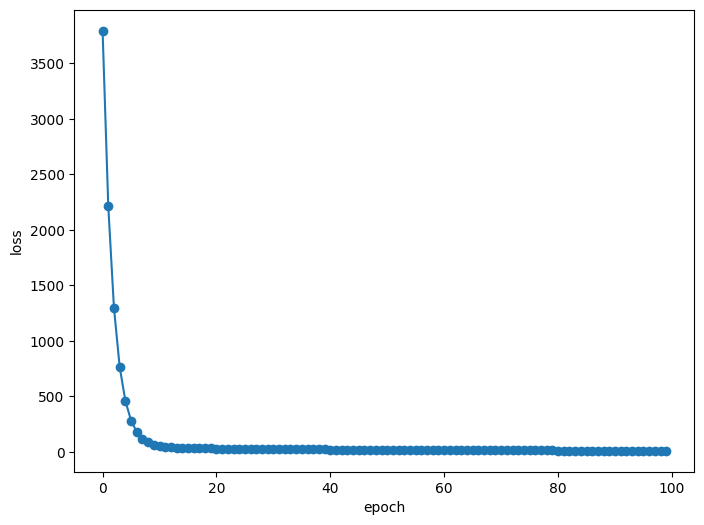

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(reg.loss_, marker='o')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

学習が大きすぎる場合（降下しない）：

In [ ]:
reg = MyLinearRegression2(eta=0.83438, n_iter=100)
reg.fit(X_train_scaled, y_train)

Text(0, 0.5, 'loss')

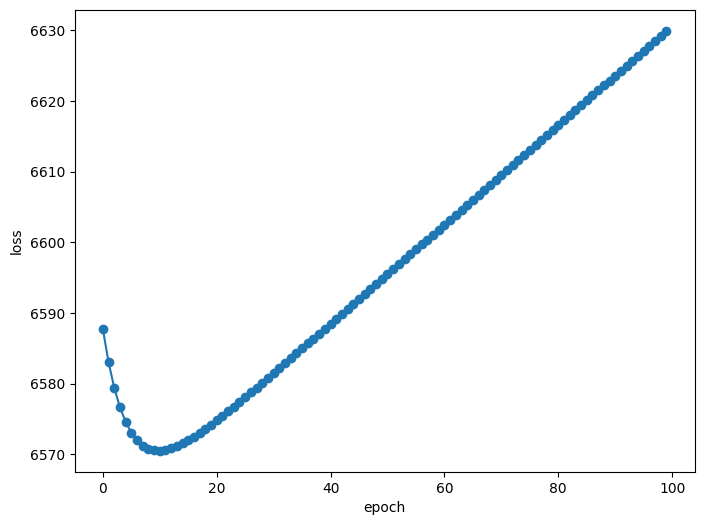

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(reg.loss_, marker='o')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

さらに学習率が大きすぎるとき

In [ ]:
reg = MyLinearRegression2(eta=2, n_iter=100)
reg.fit(X_train_scaled, y_train)

Text(0, 0.5, 'loss')

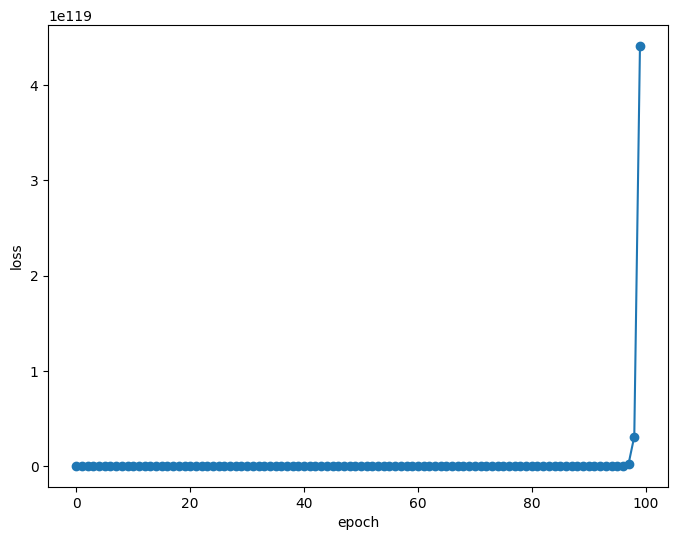

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(reg.loss_, marker='o')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

増加が激しい時は、縦軸の<b>目盛りを対数</b>にしてみる





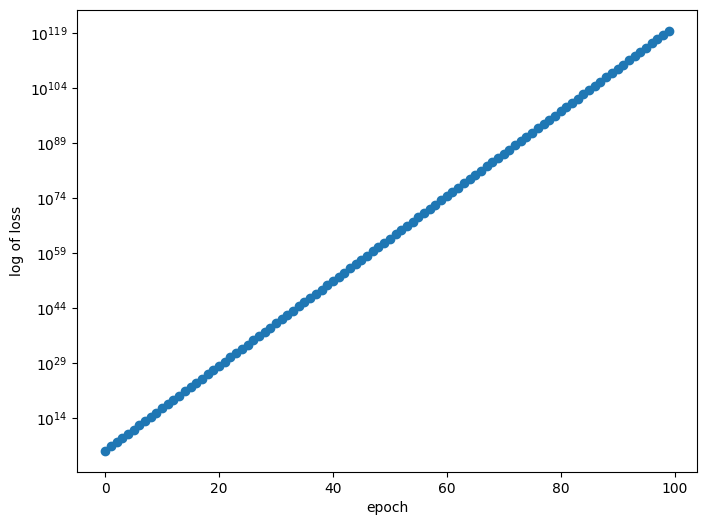

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(reg.loss_, marker='o')
ax.set_xlabel('epoch')
ax.set_ylabel('log of loss')
ax.set_yscale('log')

# 11.外挿の危険性

MinMaxScalerを使ったので、訓練データでXが取りうる範囲は0~1です。では、この範囲より先では`y`はどう予想できるでしょうか？例えばx=10では

In [ ]:
reg = SGDRegressor(max_iter=5000, eta0=0.1)
reg.fit(X_train_scaled, np.squeeze(y_train))
reg.predict([[10]])

array([169.12823531])

AIの進歩がめざましいといっても、テストでこんな点数を取る時代が来るでしょうか？100点満点のテストでそんなわけはありません。

モデルはあくまで訓練データが数値の範囲で、その範囲を超えた予測は極めて不確かで信頼できないものになります。その一方で、線形回帰はバイアスの強い手法ですので（予測区間を考慮しないと）形式的には強い外挿的予測を与えてしまいます。決定木回帰などとの大きな違いです。

データとタスクに対する我々の事前知識を使って、どこまで言えるのかは慎重に分析・診断しましょう。

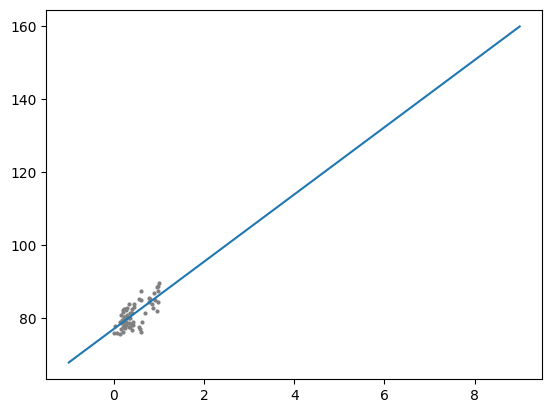

In [ ]:
x_line = np.linspace(-1,9,100)
y_line = reg.predict(x_line[:,np.newaxis])
plt.plot(x_line, y_line)
plt.scatter(X_train_scaled,y_train, s=4, c='gray')

今回の解析を予測の意味で理解すると、2017年7月から2018年10月の間の任意の時点での典型的なAIの点数をざっくり予測する、という問題を解いたことになります（遠い未来の「予測」ではありません）。

あるいは説明・記述モデリング的に理解すると、時期とAIの性能の間にある相関関係を抽出できたことになります。これにより、この期間にAIの性能が大雑把に言うと線形的に伸びていた、というざっくりとした理解が得られたことになります。

# <center>5/9 宿題</center>
＊は発展問題です。

### 宿題1(Numpyの練習)
$R^2$によるscore計算をNumpyを用いて実装して見ましょう（sklearnの出来合いの関数を使ってはいけません）。$R^2$の定義式は講義のスライド参照。

### 宿題2＊
SGDRegressorでScalerを使用しないと学習に問題が起こりました。いったい何が起こってしまったのかを、実験して調べてみましょう。sklearnやスクラッチ実装をうまく使って、誤差関数の動きなどを検討して、どんなトラブルが発生しているのかについて仮説と証拠を提示してみてください。

### 宿題3＊
scikit-learnのソースコードなどを読んで、実際の実装のアイデア・設計をレポートしてください。